<a href="https://colab.research.google.com/github/junranshi/capstone_moonboard/blob/main/generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/junranshi/capstone_moonboard.git

fatal: destination path 'capstone_moonboard' already exists and is not an empty directory.


In [ ]:
%cd /content/capstone_moonboard
!git pull

/content/capstone_moonboard
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 14 (delta 6), reused 14 (delta 6), pack-reused 0
Unpacking objects: 100% (14/14), done.
From https://github.com/junranshi/capstone_moonboard
   985260c..d1443a7  main       -> origin/main
Updating 985260c..d1443a7
Fast-forward
 .DS_Store                                          |   Bin 10244 -> 10244 bytes
 data/.DS_Store                                     |   Bin 6148 -> 6148 bytes
 .../data_analysis-checkpoint.ipynb                 |   285 +-
 data/cleaned.csv                                   | 25100 +++++++++++++++++++
 data/data_analysis.ipynb                           |   981 +-
 .../classification-checkpoint.ipynb                |   304 +-
 models/classification.ipynb                        |   304 +-
 7 files changed, 26371 insertions(+), 603 deletions(-)
 create mode 100644 data/cleaned.csv


In [ ]:
import pandas as pd
import sys
import os

py_file_location = "/content/capstone_moonboard/data"
sys.path.append(os.path.abspath(py_file_location))

In [96]:
with open('/content/capstone_moonboard/data/cleaned.p', 'rb') as f:
    mb_2016 = pickle.load(f)

In [97]:
def get_coor(hold):
    x, y = hold
    x_coor = 94 + x*51
    y_coor = 958 - y*51
    return (int(x_coor), int(y_coor))


def add_hold(hold, img, hold_type):
    """
    add hold to moonboard image
    """
    circle_color = {
        'start': (0,255,0),
        'mid': (255,0,0),
        'end': (0,0,255),
    }
    center = get_coor(hold)
    c = circle_color[hold_type]
    cv2.circle(img = img, center = center, radius = 28, color = c, thickness=5)

# main function:
def display_route(route):
    """
    display an entire route on an image
    """
    img = mb_2016_img.copy()
    for key, item in route.items():
        # key is hold type, item is list of holds
        for hold in item:
            add_hold(hold, img, key)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.gcf().set_dpi(150)
    plt.axis('off')
    plt.show()

# example:
# r = {'start': [[0,0]], 'mid': [[2,2], [6,6]], 'end': [[0,17],[4,17]]}
# display_route(r)

def draw_samples(data, n):
    """
    draw n samples of routes from data (dictionary)
    """
    samples = {}
    for item in random.sample(list(data.items()), n):
        samples[item[0]] = item[1]
    return samples

# hold types is a list of combination of 'start', 'mid', 'end'
def get_holds(item, hold_types):
    """
    get a list of holds from a route
    """
    route = []
    for t in hold_types:
        for hold in item[t]:
            route.append(hold)
    return route

def convert_matrix(list):
    """
    convert a list of holds to 11*18 matrix
    """
    matrix = np.zeros((11,18))
    for hold in list:
        x = hold[0]
        y = hold[1]
        matrix[x][y] = 1
    return matrix

def display_matrix(matrix):
    """
    flip the matrix to present as 18*11
    """
    return np.flip(matrix.T, 0)

def get_matrices(data, hold_types):
    """
    return a dictionary and a list of matrices for the data input (eg mb_2016)
    """
    d = {}
    l = []
    for key in data:
        route = get_holds(data[key], hold_types)
        d[key] = display_matrix(convert_matrix(route))
        l.append(display_matrix(convert_matrix(route)))
    return d, l

In [98]:
samples = draw_samples(mb_2016, 500)

In [105]:
sample_matrices = get_matrices(samples, ['start', 'mid', 'end'])[1]

In [114]:
resized_matrices = []
for matrix in sample_matrices:
  resized_matrices.append(np.pad(ex, ((0,2),(0,9)), mode='constant', constant_values=0))

In [109]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [120]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [121]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(20, 20, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 10, 10, 32)   320         ['input_27[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 5, 5, 64)     18496       ['conv2d_12[0][0]']              
                                                                                                  
 flatten_6 (Flatten)            (None, 1600)         0           ['conv2d_13[0][0]']              
                                                                                            

In [122]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5*5 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((5, 5, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_27 (Dense)            (None, 1600)              4800      
                                                                 
 reshape_20 (Reshape)        (None, 5, 5, 64)          0         
                                                                 
 conv2d_transpose_47 (Conv2D  (None, 10, 10, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_48 (Conv2D  (None, 20, 20, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_49 (Conv2D  (None, 20, 20, 1)        289 

In [123]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [132]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
##mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(resized_matrices, epochs=30, batch_size=128)

Epoch 1/30
4/4 [==============================] - 2s 110ms/step - loss: 275.4493 - reconstruction_loss: 274.2609 - kl_loss: 5.6791e-04
Epoch 2/30
4/4 [==============================] - 0s 103ms/step - loss: 264.7237 - reconstruction_loss: 262.4297 - kl_loss: 0.0080
Epoch 3/30
4/4 [==============================] - 0s 105ms/step - loss: 243.0189 - reconstruction_loss: 238.0484 - kl_loss: 0.0528
Epoch 4/30
4/4 [==============================] - 0s 104ms/step - loss: 200.2026 - reconstruction_loss: 191.4901 - kl_loss: 0.2417
Epoch 5/30
4/4 [==============================] - 0s 104ms/step - loss: 136.5188 - reconstruction_loss: 125.1040 - kl_loss: 0.9745
Epoch 6/30
4/4 [==============================] - 0s 108ms/step - loss: 82.1432 - reconstruction_loss: 75.0812 - kl_loss: 4.2947
Epoch 7/30
4/4 [==============================] - 0s 103ms/step - loss: 78.8325 - reconstruction_loss: 71.8717 - kl_loss: 6.7595
Epoch 8/30
4/4 [==============================] - 0s 108ms/step - loss: 66.6451 - r

In [130]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)

resized_matrices = np.expand_dims(resized_matrices, -1).astype("float32")

#vae = VAE(encoder, decoder)
#vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(mnist_digits, epochs=30, batch_size=128)

In [131]:
resized_matrices[0].shape

(20, 20, 1)

In [225]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 20
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


#plot_latent_space(vae)

In [327]:
n=8
digit_size = 20
scale = 1.0
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

generated = []

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit
        generated.append(digit)

1/1 [==============================] - 0s 21ms/step


In [328]:
generated_routes_matrices = []
for route in generated:
  resized_route = []
  for row in route[:18]:
    resized_route.append(row[0:11])
  generated_routes_matrices.append(np.array(resized_route))

In [329]:
generated_routes = []
for matrix in generated_routes_matrices:
  route_list = []
  for i in range(0,18):
    for j in range(0,11):
      if matrix[i,j] < 0.34:
        matrix[i,j] = 0
      else:
        matrix[i,j] = 1
        route_list.append([j, 17-i])
  generated_routes.append(route_list)

In [330]:
print(generated_routes_matrices[0])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [331]:
for route in generated_routes:
  print(route)

[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [4, 14], [6, 13], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6, 13], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]
[[4, 17], [6, 16], [6,

In [323]:
import cv2
mb_2016_img = cv2.imread('/content/capstone_moonboard/images/mb_2016_img.jpeg')

In [324]:
def display_route(route):
    """
    display an entire route on an image
    """
    img = mb_2016_img.copy()
    for hold in route:
        add_hold(hold, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.gcf().set_dpi(150)
    plt.axis('off')
    plt.show()

def add_hold(hold, img):
    """
    add hold to moonboard image
    """
    circle_color = {
        'start': (0,255,0),
        'mid': (255,0,0),
        'end': (0,0,255),
    }
    center = get_coor(hold)
    cv2.circle(img = img, center = center, color = (0,255,0), radius = 28, thickness=5)
def get_coor(hold):
    x, y = hold
    x_coor = 94 + x*51
    y_coor = 958 - y*51
    return (int(x_coor), int(y_coor))

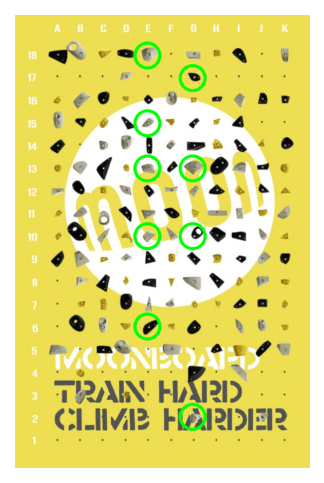

[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]


In [325]:
display_route(generated_routes[0])
print(generated_routes[0])

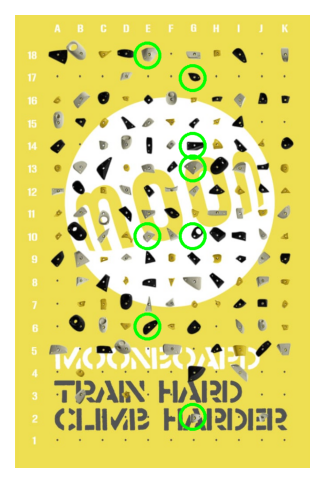

[[4, 17], [6, 16], [4, 14], [4, 12], [6, 12], [4, 9], [6, 9], [4, 5], [6, 1]]


In [326]:
display_route(generated_routes[2])
print(generated_routes[0])

In [182]:
flat = []
for sublist in additional:
    for item in sublist:
        flat.append(item)
max(flat)

0.038892772

In [184]:
digit = digit.flatten()
max(digit)

0.38822585